# Import Relevant Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
import corner
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
from astropy.table import Table

# Simulate data
Simulate data with a smooth broken power law, with injected noise, following the model below:

$S_\nu(t) = S_{\rm \nu,peak} \left[ \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_1} + \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_2}\right]^{-1/s}$

Let us assume that all of our data is in a narrow enough frequency band that we do not have to consider the power law spectrum:

$ S_\nu(\nu) \propto \nu^\alpha$


In [4]:
# define smooth broken power law function
def smooth_broken_power_law(t, S_peak, t_peak, delta_1, delta_2, log_s):
    s = 10**log_s
    y = S_peak*((t/t_peak)**(-s*delta_1) + (t/t_peak)**(-s*delta_2))**(-1/s)
    return y

# define our input parameters
t = np.logspace(0, 3, 100)
S_peak = 100
t_peak = 150
delta_1 = 1.1
delta_2 = -0.8
log_s = 0.5

# generate smooth broken power law
true_relation = smooth_broken_power_law(t, S_peak, t_peak, delta_1, delta_2, log_s)

# inject gaussian noise 
ltnoise = np.random.normal(scale= 2, size=len(t))
gtnoise = np.random.normal(scale= 15, size=len(t))

# I will not add any errors for now as I am not sure how to deal with scaling the errors with the log scale
# err = np.random.normal(loc= 1, scale= 0.1, size=len(t))

table = np.column_stack((t, true_relation, 100*abs(ltnoise)))
data = Table(table, names=['time', 'flux', 'rms'])
for i in range(0,len(data['time'])):
    if data['flux'][i] < 10:
        data['flux'][i] = data['flux'][i] + ltnoise[i]
    else:
        data['flux'][i] = data['flux'][i] + gtnoise[i]

data

time,flux,rms
float64,float64,float64
1.0,3.918851774353012,351.4927814740719
1.0722672220103233,0.33747058627510806,9.867647278330084
1.1497569953977358,1.9832413117973244,151.23005503037876
1.2328467394420661,1.151592663884879,64.30825266964769
1.321941148466029,1.5584582820731911,100.93816661453248
1.4174741629268053,-0.03422883793363929,62.71081300274567
1.5199110829529336,-3.0489074540070265,368.90837878682936
1.6297508346206442,-1.475716371121123,216.69628759344118
1.7475284000076838,0.09285023877904686,65.35405681639897


# Make a plot of the lightcurve
follow the same modular procedure as in the <span style="text-decoration: underline;">Radio Light Curve Module</span> notebook

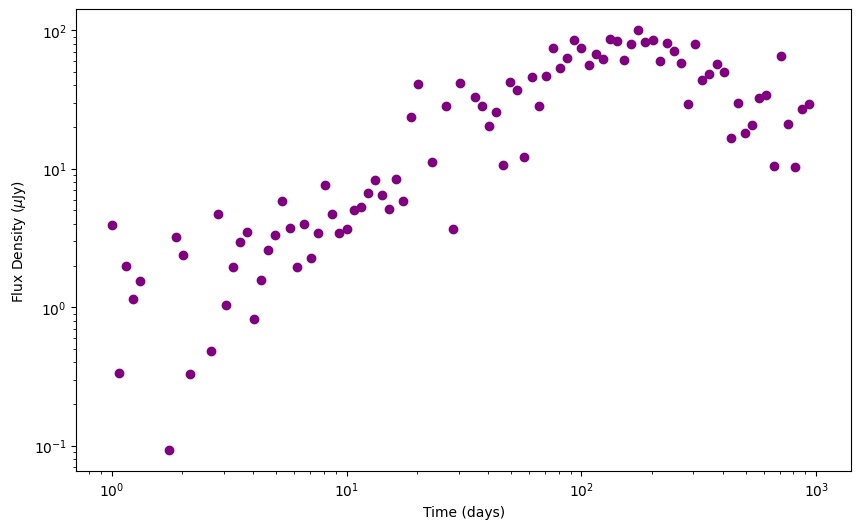

In [5]:
def plot_data(ax, data, scaled=False, **kwargs):
    for row in data:
        time = row['time']
        
        if scaled:
            flux = row['scaled_flux']
            # rms = row['scaled_rms']
        else:
            flux = row['flux']
            # rms = row['rms']

        ax.scatter(time, flux, color='purple', marker='o')
    return

def make_plot(data, scaled=False, model=None, params=None, tvals=np.arange(10,400), plot_models=False):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    plot_data(ax, data, scaled=scaled)

    # set axis scales to log
    ax.set_yscale('log')
    ax.set_xscale('log')

    #Label axes, set axis limits etc.
    ax.set_xlabel('Time (days)')
    if scaled:
        ax.set_ylabel('Scaled Flux Density ($\mu$Jy)')
        ax.set_title('Scaled to 3 GHz')
    else:
        ax.set_ylabel('Flux Density ($\mu$Jy)')

    if model!=None:
        plot_model(model, params, data['time'], ax)

make_plot(data)

# Determing and scaling data based on spectral index
If we had information across frequencies, we would perform this step. I will skip this step for now and just assume the 'data' is scaled to one frequency.

# Fitting the data with MCMC and determining evidence for a turnover
We will now try to fit our simulated data to two models, one with a turnover, and another without. We will perform an MCMC  fit using the [`lmfit`](https://lmfit.github.io/lmfit-py/) package to determine the lightcurve parameters of our data. 